In [1]:
%load_ext autoreload
%autoreload 2
import extract_environment as ee
import time
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import geopy.distance

import os
import xarray as xr
import dask
from dask.distributed import Client


In [2]:
dir_env = '/home/kbrennan/phd/data/climate/present'
dir_track = '/home/kbrennan/phd/data/climate/tracks/present'
day = '20210628'

now = pd.to_datetime(day+'19', format='%Y%m%d%H')

In [3]:
subdomains = xr.open_dataset('/home/kbrennan/phd/data/climate/grids/subdomains_rot.nc')

In [4]:
subdomains = subdomains.drop(['time_bnds','rotated_pole'])
subdomains = subdomains.squeeze()

In [30]:
subdomains.AL

<xarray.DataArray 'AL' (rlat: 1542, rlon: 1542)>
[2377764 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2020-03-19T03:00:00
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
  * rlon     (rlon) float32 -18.86 -18.84 -18.82 -18.8 ... 11.92 11.94 11.96
  * rlat     (rlat) float32 -14.86 -14.84 -14.82 -14.8 ... 15.92 15.94 15.96
Attributes:
    standard_name:  AL
    long_name:      Alps 5,15,44,48
    grid_mapping:   rotated_pole

In [6]:
cells = ee.load_cells(dir_track, day)

In [7]:
cell = cells[83]

In [8]:
env = ee.load_environments(dir_env, now)

In [9]:
const = ee.load_constants(dir_env)
env = xr.merge([env, const], combine_attrs="override", compat="override")

In [23]:
cookie = ee.cutout_cookie(cell, env, now)
cookie = ee.add_secondary_variables(cookie)

cookie = ee.rotate_cookie(cookie, cell)

cookie = ee.mask_disk(cookie, 25)

# cookie = ee.mask_topography(cookie)


In [28]:
cookie.rlat.sel(x=0, y=0, method='nearest')

<xarray.DataArray 'rlat' ()>
array(-0.47999999)
Coordinates:
    time     datetime64[ns] 2021-06-28T19:00:00
    x        float64 0.0
    y        float64 0.0
Attributes:
    units:      degrees_north
    long_name:  latitude in rotated pole grid

In [8]:
u_storm = np.nanmean(cell["delta_y"][1::])
v_storm = np.nanmean(cell["delta_x"][1::])

In [9]:
cookie = ee.add_secondary_variables(cookie)
cookie

<xarray.Dataset>
Dimensions:     (pressure: 8, x: 51, y: 51)
Coordinates:
  * pressure    (pressure) float32 200.0 300.0 400.0 500.0 ... 700.0 850.0 925.0
  * x           (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y           (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
    time        datetime64[ns] 2021-06-28T19:00:00
Data variables: (12/69)
    U_10M       (y, x) float32 1.068 1.325 2.461 ... 0.05968 -0.8192 -1.662
    V_10M       (y, x) float32 0.698 0.4855 -0.1347 ... 0.7165 0.5539 0.6513
    VMAX_10M    (y, x) float32 10.28 10.96 13.94 13.15 ... 6.226 6.339 5.71
    T_2M        (y, x) float32 289.2 287.9 286.1 285.0 ... 290.7 290.4 290.2
    TD_2M       (y, x) float32 287.1 286.5 285.6 284.6 ... 288.8 288.6 288.4
    RELHUM_2M   (y, x) float32 87.72 91.31 96.9 97.61 ... 87.4 88.7 89.38 89.11
    ...          ...
    THETA       (pressure, y, x) float32 345.5 345.1 345.0 ... 297.2 297.1 296.7
    THETA_2M    (y, x) float32 294.4 294.8 295.4 296.8 ... 295.8 296.1 296.3
    THETA_E     (pressure, y, x) float32 345.6 345.2 345.1 ... 328.9 329.0 330.1
    THETA_E_2M  (y, x) float32 325.4 325.3 325.1 325.6 ... 330.5 330.5 330.5
    VORT        (pressure, y, x) float64 0.09486 0.02592 ... 0.2068 0.8389
    DIV         (pressure, y, x) float64 0.544 0.4868 0.4642 ... -0.3649 1.172
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-29 12:37:13

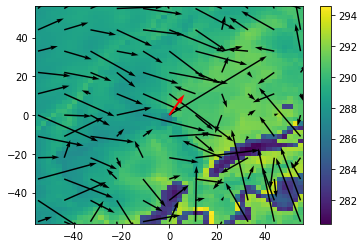

In [10]:
pressure = 925
plt.pcolormesh(cookie.x,cookie.y,cookie.T.sel(pressure= pressure))
plt.colorbar()
stride= 5
plt.quiver(cookie.x[::stride],cookie.y[::stride],cookie.U.sel(pressure=pressure)[::stride,::stride],cookie.V.sel(pressure=pressure)[::stride,::stride], scale=30)
plt.quiver(0,0,u_storm,v_storm, scale=30, color='r')

In [11]:
r_cookie = ee.rotate_cookie(cookie,cell)

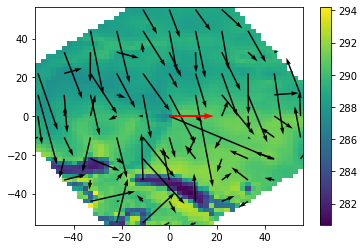

In [12]:
pressure = 925
plt.pcolormesh(r_cookie.x,r_cookie.y,r_cookie.T.sel(pressure= pressure))
plt.colorbar()
stride= 5
plt.quiver(cookie.x[::stride],r_cookie.y[::stride],r_cookie.U.sel(pressure=pressure)[::stride,::stride],r_cookie.V.sel(pressure=pressure)[::stride,::stride], scale=30)
plt.quiver(0,0,5,0, scale=30, color='r')

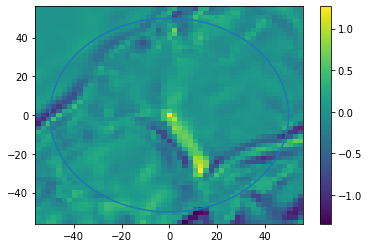

In [13]:
plt.pcolormesh(cookie.x,cookie.y,cookie.W.sel(pressure=925).squeeze())
plt.colorbar()
# plot circle
circle = plt.plot(np.sin(np.linspace(0,2*np.pi,100))*50,np.cos(np.linspace(0,2*np.pi,100))*50)

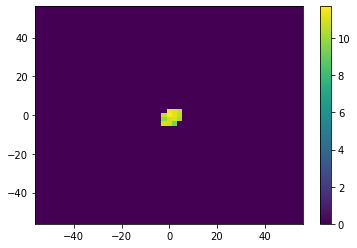

In [14]:
plt.pcolormesh(cookie.x,cookie.y,cookie.DHAIL_MX)
plt.colorbar()

In [15]:
inpath = "/home/kbrennan/phd/data/climate/cookies/present"

# load data
dset = xr.open_mfdataset(inpath + "/*.nc", combine="by_coords", parallel=True)

In [16]:
dset

<xarray.Dataset>
Dimensions:        (cookie_id: 1192, x: 51, y: 51, pressure: 8)
Coordinates:
  * cookie_id      (cookie_id) int64 202106010001100 ... 202106300037400
  * pressure       (pressure) float32 200.0 300.0 400.0 ... 700.0 850.0 925.0
  * x              (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y              (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
Data variables: (12/78)
    U_10M          (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    V_10M          (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    VMAX_10M       (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    T_2M           (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    TD_2M          (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    RELHUM_2M      (cookie_id, x, y) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    ...             ...
    max_val        (cookie_id) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    real_time      (cookie_id) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_start    (cookie_id) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_end      (cookie_id) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_max      (cookie_id) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    itime          (cookie_id) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:                         COSMO driven by ERA5
    source:                        COSMO_5.08
    Conventions:                   CF-1.4
    conventionsURL:                http://www.cfconventions.org/
    creation_date:                 202405061759
    cookie_creator:                extract_environment.py
    cookie_creator_version:        0.1
    cookie_creator_version_date:   20240502
    cookie_creator_author:         Killian P. Brennan
    horizontal coordinate system:  x and y are relative to the cell center, x...
    vertical coordinate system:    pressure levels are in hPa

In [83]:
dset.cookie_id

<xarray.DataArray 'cookie_id' (cookie_id: 1192)>
array([202106010001100, 202106010004200, 202106010004201, ..., 202106300035801,
       202106300035802, 202106300037400])
Coordinates:
  * cookie_id  (cookie_id) int64 202106010001100 ... 202106300037400
Attributes:
    long_name:  unique identifier for the cookie, constructed from YYYYMMDD +...

In [18]:
# compute stats in parallel
# mean over cell_id
mean = dset.mean(dim="cookie_id", skipna=True)
# 90th percentile over cell_id
# p90 = dset.quantile(0.9, dim="cookie_id", skipna=True)
# standard deviation over cell_id
# std = dset.std(dim="cookie_id", skipna=True)

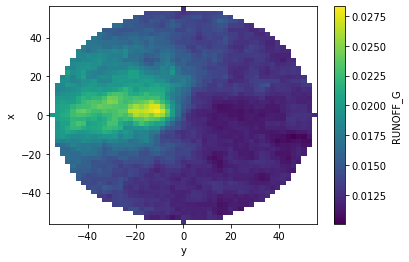

In [19]:
mean.RUNOFF_G.plot()

In [20]:
# mean = mean.compute()

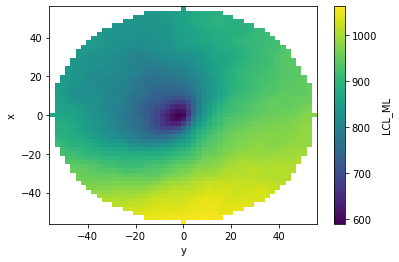

In [21]:
mean.LCL_ML.plot()

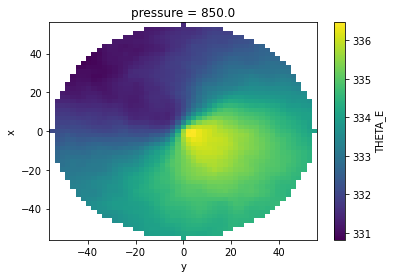

In [22]:
mean.THETA_E.sel(pressure=850).plot()

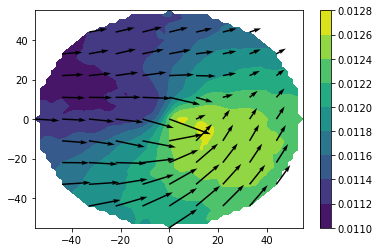

In [23]:
pressure = 925
plt.contourf(mean.x,mean.y,mean.QV.sel(pressure= pressure))
plt.colorbar()
stride= 5
plt.quiver(mean.x[::stride],mean.y[::stride],mean.U.sel(pressure=pressure)[::stride,::stride],mean.V.sel(pressure=pressure)[::stride,::stride], scale=50)

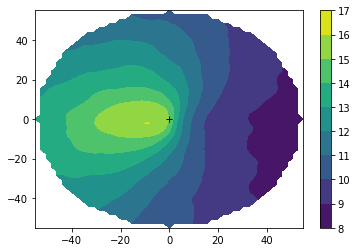

In [24]:
plt.contourf(mean.x,mean.y,mean.VMAX_10M)
plt.colorbar()
plt.plot(0,0,'k+')

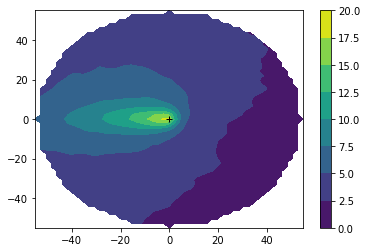

In [25]:
plt.contourf(mean.x,mean.y,mean.W_CTMAX)
plt.colorbar()
plt.plot(0,0,'k+')

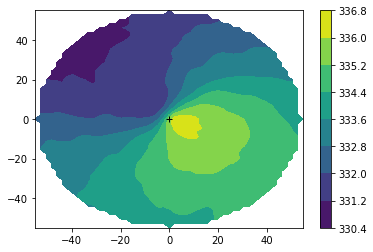

In [26]:
plt.contourf(mean.x,mean.y,mean.THETA_E.sel(pressure=850))
plt.colorbar()
plt.plot(0,0,'k+')

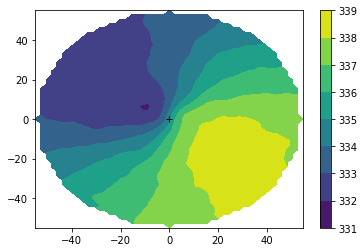

In [27]:
plt.contourf(mean.x,mean.y,mean.THETA_E.sel(pressure=925))
plt.colorbar()
plt.plot(0,0,'k+')

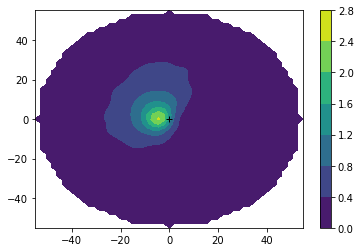

In [28]:
plt.contourf(mean.x,mean.y,mean.TOT_PREC)
plt.colorbar()
plt.plot(0,0,'k+')

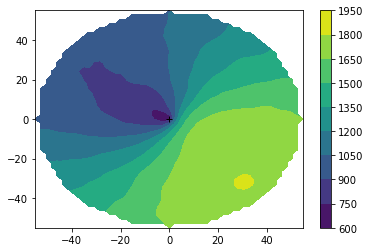

In [29]:
plt.contourf(mean.x,mean.y,mean.CAPE_MU)
plt.colorbar()
plt.plot(0,0,'k+')

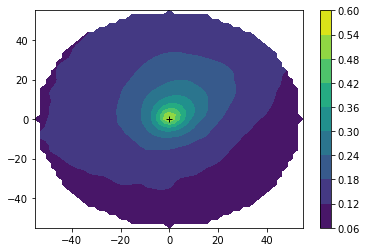

In [30]:
plt.contourf(mean.x,mean.y,mean.TQI)
plt.colorbar()
plt.plot(0,0,'k+')

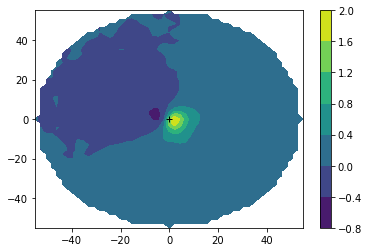

In [31]:
plt.contourf(mean.x,mean.y,mean.W.sel(pressure=850))
plt.plot(0,0,'k+')
plt.colorbar()

/tmp/ipykernel_24340/1248534744.py:3: UserWarning: No contour levels were found within the data range.
  plt.contour(mean.x,mean.y,mean.W.sel(pressure=850),levels=[5],colors='k')


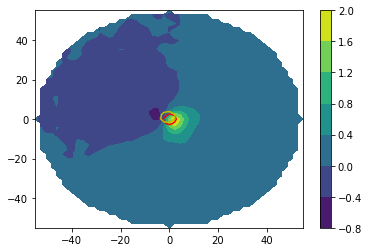

In [32]:
plt.contourf(mean.x,mean.y,mean.W.sel(pressure=850))
plt.colorbar()
plt.contour(mean.x,mean.y,mean.W.sel(pressure=850),levels=[5],colors='k')
plt.contour(mean.x,mean.y,mean.W.sel(pressure=600),levels=[5],colors='r')
plt.contour(mean.x,mean.y,mean.W.sel(pressure=300),levels=[5],colors='y')

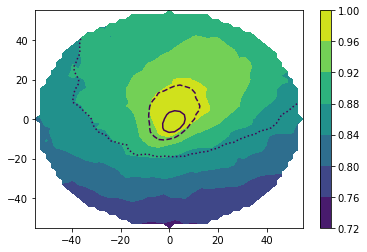

In [34]:
plt.contourf(mean.x,mean.y,mean.CLCT)
plt.colorbar()
plt.contour(mean.x,mean.y,mean.CLCL,levels=[0.6],linestyles=['solid'])
plt.contour(mean.x,mean.y,mean.CLCM,levels=[0.7],linestyles=['dashed'])
plt.contour(mean.x,mean.y,mean.CLCH,levels=[0.8],linestyles=['dotted'])